In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
from matplotlib.animation import FuncAnimation as anim
from IPython.display import Image
from celluloid import Camera

In [104]:
G = 6.67 * 10**-11
M = 1.9891 * 10**30
m = 5.97219 * 10**24

In [56]:
def set_initial(G, M, m, aphe, peri):
    # start at aphelion
    r = aphe
    com = r * m / (M + m)
    r_M = com
    r_m = r - com

    # eccentricity of Earth's orbit
    ecc = (aphe - peri) / (aphe + peri)
    a = (1/2) * (aphe + peri)
    mu = M + m
    omega = math.sqrt(G * mu * ((1 - ecc) / (1 + ecc) / a)) / r
    v_earth = omega * r_m
    v_sun = -omega * r_M
    
    # time and time step of orbit
    T = math.sqrt(4 * math.pi**2 * a**3 / (G * (M + m)))
    dt = T / 1000

    # center of mass motion
    mu = M * m / (M + m)
    L_earth = mu * v_earth * r
    L_sun = 0
    
    return G, M, m, r, T, dt, v_earth, v_sun, mu, L_earth, L_sun

In [57]:
def reset(v_sun, v_earth, r):
    return np.array([0.0, 0.0]), np.array([0.0, v_sun]), np.array([r, 0.0]), np.array([0.0, v_earth])

# get the magnitude of the vector
def mag(vec):
    return math.sqrt(vec[0]**2 + vec[1]**2)

def dot(vec_a, vec_b):
    return vec_a[0] * vec_b[0] + vec_a[1] * vec_b[1]

def cross(vec_a, vec_b):
    return vec_a[0] * vec_b[1] - vec_a[1] * vec_b[0]

# the distance between two objects
def distance(object_a, object_b):
    return math.sqrt((object_a[0]-object_b[0])**2 + (object_a[1]-object_b[1])**2)

# the direction vector pointing from the first object to the second object
def direction(object_a, object_b):
    return (object_b - object_a) / distance(object_a, object_b)

# the gravitational force on the first object
def force(G, object_a, object_b, mass_a, mass_b):
    return G * mass_a * mass_b / distance(object_a, object_b)**2 * direction(object_a, object_b)

# small time step
def move_es_system(G, M, m, sun_pos, sun_vel, earth_pos, earth_vel, dt):
    earth_vel += force(G, earth_pos, sun_pos, m, M) / m * dt
    earth_pos += earth_vel * dt
    sun_vel += force(G, sun_pos, earth_pos, M, m) / M * dt
    sun_pos += sun_vel * dt

# effective potential of earth
def v_eff_e(G, M, m, mu, L_earth, sun_pos, earth_pos):
    return -G * M * m / math.sqrt(dot(earth_pos, earth_pos)) + L_earth**2 / (2 * mu * dot(earth_pos, earth_pos))

# effective potential given angular momentum and distance
def v_eff(G, M, m, mu, r, L):
    return -G * M * m / r + L**2 / (2 * mu * r**2)

In [58]:
def simulate(G, M, m, aphe, peri, name):
    G, M, m, r, T, dt, v_earth, v_sun, mu, L_earth, L_sun = set_initial(G, M, m, aphe, peri)
    sun_pos, sun_vel, earth_pos, earth_vel = reset(v_sun, v_earth, r)

    fig, (axis, potential) = plt.subplots(1, 2)
    axis.axis('equal')
    axis.set_xlim(-peri*1.05, aphe*1.05)
    axis.set_ylim(-peri, peri)
    axis.set_title("Orbit")
    potential.set_title("Earth Gravitational Potential")
    camera = Camera(fig)

    path = [[], []]
    d = np.linspace(peri * 0.99, aphe * 1.01)

    t = 0
    while t <= T:
        # generate next location
        path[0].append(earth_pos[0])
        path[1].append(earth_pos[1])
        move_es_system(G, M, m, sun_pos, sun_vel, earth_pos, earth_vel, dt)
        t += dt

    sun_pos, sun_vel, earth_pos, earth_vel = reset(v_sun, v_earth, r)
    t = 0
    switch = 20
    counter = 0
    while t < T:
        if counter == switch:
            potential.scatter(distance(sun_pos, earth_pos), v_eff_e(G, M, m, mu, L_earth, sun_pos, earth_pos), c='b')
            potential.plot(d, v_eff(G, M, m, mu, d, L_earth), c='k')
            axis.scatter([sun_pos[0], earth_pos[0]], [sun_pos[1], earth_pos[1]], s=[100, 10], c=['y','b'])
            axis.plot(path[0], path[1], 'k--')
            camera.snap()
            counter = 1
        else:
            counter += 1
        move_es_system(G, M, m, sun_pos, sun_vel, earth_pos, earth_vel, dt)
        t += dt

    plt.close()
    animation = camera.animate()
    animation.save(name, writer="PillowWriter", fps=60)

MovieWriter PillowWriter unavailable; using Pillow instead.


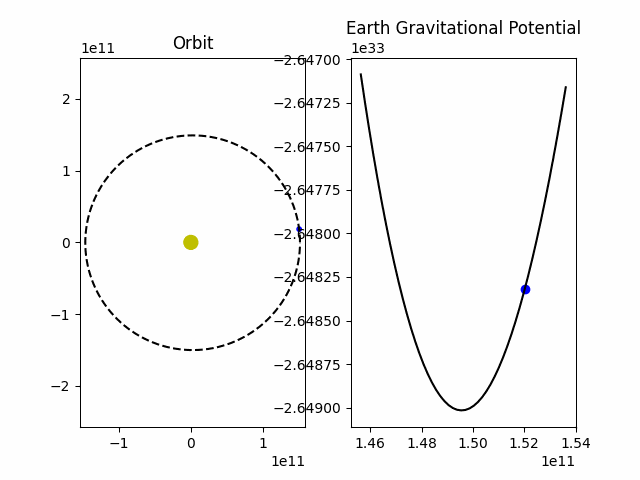

In [27]:
simulate(G, M, m, 1.52097701 * 10**11, 1.47098074 * 10**11, 'Sun_Earth_System.gif')
Image(filename='Sun_Earth_System.gif')

MovieWriter PillowWriter unavailable; using Pillow instead.


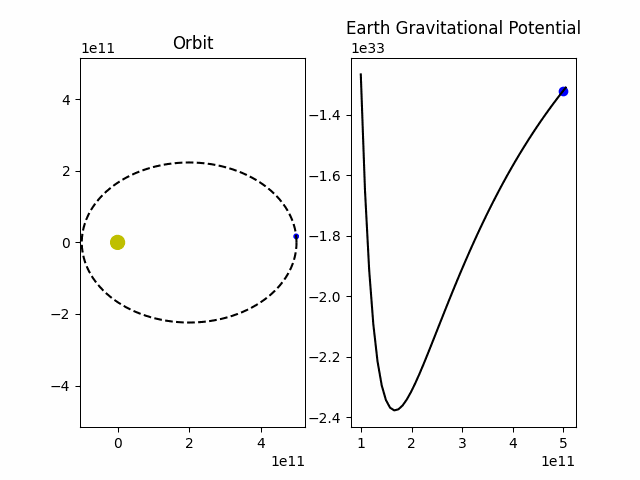

In [28]:
simulate(G, M, m, 5 * 10**11, 1 * 10**11, 'Eccentric_System.gif')
Image(filename='Eccentric_System.gif')

In [70]:
def simulate_binary(G, M, m, aphe, peri, name):
    G, M, m, r, T, dt, v_earth, v_sun, mu, L_earth, L_sun = set_initial(G, M, m, aphe, peri)
    sun_pos, sun_vel, earth_pos, earth_vel = reset(v_sun, v_earth, r)

    fig, (axis) = plt.subplots(1, 1)
    axis.axis('equal')
    axis.set_xlim(-peri*1.05, aphe*1.05)
    axis.set_ylim(-peri, peri)
    axis.set_title("Orbit in Coordinate Space")
    camera = Camera(fig)

    path = [[], []]
    d = np.linspace(peri * 0.99, aphe * 1.01)

    t = 0
    while t <= T:
        # generate next location
        path[0].append(earth_pos[0])
        path[1].append(earth_pos[1])
        move_es_system(G, M, m, sun_pos, sun_vel, earth_pos, earth_vel, dt)
        t += dt

    sun_pos, sun_vel, earth_pos, earth_vel = reset(v_sun, v_earth, r)
    t = 0
    switch = 20
    counter = 0
    while t < T:
        if counter == switch:
            axis.scatter([sun_pos[0], earth_pos[0]], [sun_pos[1], earth_pos[1]], s=[100, 10], c=['y','b'])
            axis.plot(path[0], path[1], 'k--')
            camera.snap()
            counter = 1
        else:
            counter += 1
        move_es_system(G, M, m, sun_pos, sun_vel, earth_pos, earth_vel, dt)
        t += dt

    plt.close()
    animation = camera.animate()
    animation.save(name, writer="PillowWriter", fps=60)

MovieWriter PillowWriter unavailable; using Pillow instead.


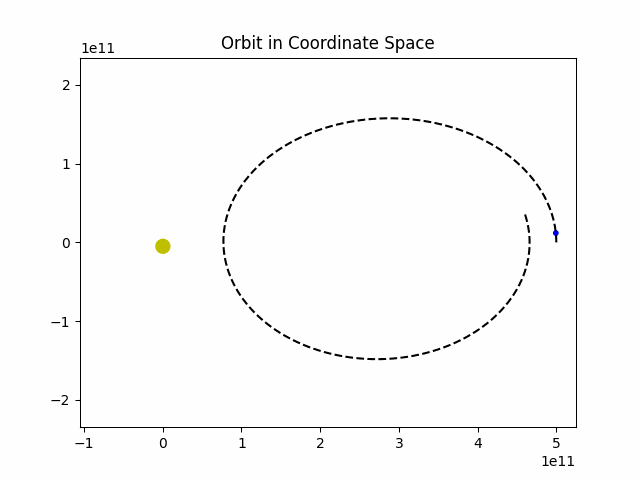

In [71]:
simulate_binary(G, 2400, 1000, 5 * 10**11, 1 * 10**11, 'Binary_System.gif')
Image(filename='Binary_System.gif')

In [8]:
def move_third_body(G, M, m, n_m, sun_pos, earth_pos, n_pos, n_vel, dt):
    n_vel += force(G, n_pos, sun_pos, n_m, M) / n_m * dt
    n_vel += force(G, n_pos, earth_pos, n_m, m) / n_m * dt
    n_pos += n_vel * dt

# third_body = [n_mass, n_pos, n_vel], n_pos = np.array([x, y]), n_vel = np.array([v_x, v_y])
def simulate_with_third_body(G, M, m, aphe, peri, third_body, periods, name):
    G, M, m, r, T, dt, v_earth, v_sun, mu, L_earth, L_sun = set_initial(G, M, m, aphe, peri)
    T *= periods
    sun_pos, sun_vel, earth_pos, earth_vel = reset(v_sun, v_earth, r)
    
    # third body initial parameters
    n_m, n_pos, n_vel = third_body[0], third_body[1], third_body[2]

    fig, axis = plt.subplots(1)
    axis.axis('equal')
    axis.set_xlim(-peri*1.05, aphe*1.05)
    axis.set_ylim(-peri, peri)
    camera = Camera(fig)

    path = [[], []]
    d = np.linspace(peri * 0.99, aphe * 1.01)

    t = 0
    while t < T:
        # generate next location
        path[0].append(earth_pos[0])
        path[1].append(earth_pos[1])
        move_es_system(G, M, m, sun_pos, sun_vel, earth_pos, earth_vel, dt)
        t += dt

    sun_pos, sun_vel, earth_pos, earth_vel = reset(v_sun, v_earth, r)
    t = 0
    switch = 20
    counter = 0
    while t <= T:
        if counter == switch:
            # plot the earth-sun system
            axis.scatter([sun_pos[0], earth_pos[0]], [sun_pos[1], earth_pos[1]], s=[100, 10], c=['y','b'])
            
            # plot the third body
            axis.scatter(n_pos[0], n_pos[1], s=1, c='r')
            
            # take the picture
            camera.snap()
            counter = 1
        else:
            counter += 1
        move_third_body(G, M, m, n_m, sun_pos, earth_pos, n_pos, n_vel, dt)
        move_es_system(G, M, m, sun_pos, sun_vel, earth_pos, earth_vel, dt)
        t += dt

    plt.close()
    animation = camera.animate()
    animation.save(name, writer="PillowWriter", fps=60)

MovieWriter PillowWriter unavailable; using Pillow instead.


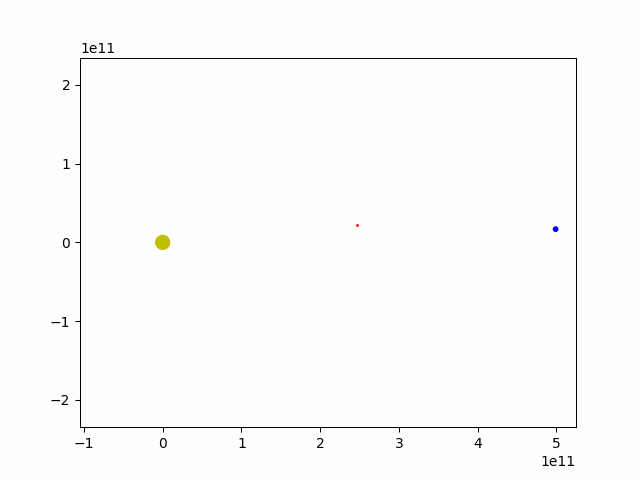

In [59]:
simulate_with_third_body(G, M, m, 5 * 10**11, 1 * 10**11, [100, np.array([2.5 * 10**11, 0.0]), np.array([0.0, 1.25 * 10**4])], 10, 'Three_Body_System.gif')
Image(filename='Three_Body_System.gif')

In [10]:
def simulate_with_multiple_bodies(G, M, m, aphe, peri, bodies, periods, name, c):
    G, M, m, r, T, dt, v_earth, v_sun, mu, L_earth, L_sun = set_initial(G, M, m, aphe, peri)
    T *= periods
    sun_pos, sun_vel, earth_pos, earth_vel = reset(v_sun, v_earth, r)
    
    # initial parameters with optional color parameter
    num_bodies = len(bodies[0])
    n_m, n_pos, n_vel = bodies[0], bodies[1], bodies[2]
    if len(bodies) > 3:
        n_color = bodies[3]
    else:
        n_color = ['r' for i in range(num_bodies)]

    fig, axis = plt.subplots(1)
    axis.axis('equal')
    axis.set_xlim(-c * peri*1.05, c * aphe*1.05)
    axis.set_ylim(-c * peri, c * peri)
    camera = Camera(fig)

    path = [[], []]
    d = np.linspace(peri * 0.99, aphe * 1.01)

    sun_pos, sun_vel, earth_pos, earth_vel = reset(v_sun, v_earth, r)
    t = 0
    switch = 20
    counter = 0
    while t < T:
        if counter == switch:
            # plot the earth-sun system
            axis.scatter([sun_pos[0], earth_pos[0]], [sun_pos[1], earth_pos[1]], s=[100, 10], c=['y','b'])
            
            # plot the other bodies assuming no interaction
            for i in range(num_bodies):
                axis.scatter(n_pos[i][0], n_pos[i][1], s=1, c=n_color[i])
            
            # take the picture
            camera.snap()
            counter = 1
        else:
            counter += 1
        for i in range(num_bodies):
            move_third_body(G, M, m, n_m[i], sun_pos, earth_pos, n_pos[i], n_vel[i], dt)
        move_es_system(G, M, m, sun_pos, sun_vel, earth_pos, earth_vel, dt)
        t += dt

    plt.close()
    animation = camera.animate()
    animation.save(name, writer="PillowWriter", fps=60)

MovieWriter PillowWriter unavailable; using Pillow instead.


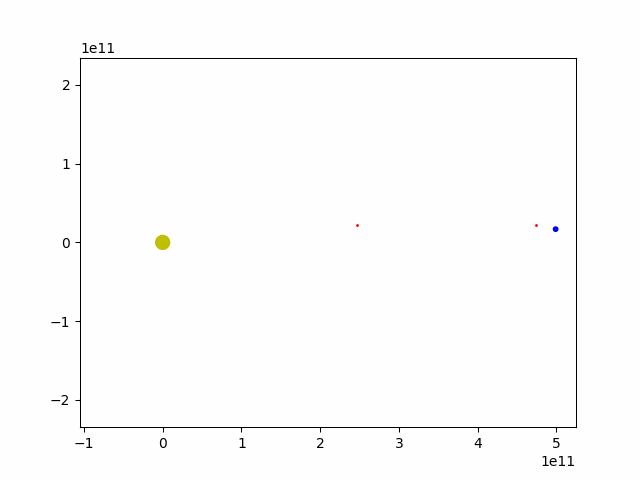

In [60]:
simulate_with_multiple_bodies(G, M, m, 5 * 10**11, 1 * 10**11, [[100, 100], [np.array([2.5 * 10**11, 0.0]), np.array([4.75 * 10**11, 0.0])], [np.array([0.0, 1.25 * 10**4]), np.array([0.0, 1.25 * 10**4])], ['r', 'r']], 3, 'Many_Body_System.gif', 1)
Image(filename='Many_Body_System.gif')

In [112]:
def L1(M, m, x, r, r_m, e_pos, iterations):
    for i in range(iterations):
        x = math.sqrt((m / M) * r_m * r**2 * (r - x)**2 / (r_m * r**2 - (r_m - x) * (r - x)**2))
    return (r - x) * e_pos / mag(e_pos)

def L2(M, m, x, r, r_m, e_pos, iterations):
    for i in range(iterations):
        x = math.sqrt((m / M) * r_m * r**2 * (r + x)**2 / ((r_m + x) * (r + x)**2 - r_m * r**2))
    return (r + x) * e_pos / mag(e_pos)

def L3(M, m, x, r, r_M, e_pos, iterations):
    for i in range(iterations):
        x = math.sqrt((M / m) * r_M * r**2 * (r + x)**2 / ((r_M + x) * (r + x)**2 - r_M * r**2))
    return -x * e_pos / mag(e_pos)

def L4(r, e_pos):
    e_perp = np.array([-e_pos[1], e_pos[0]])
    return (r / 2) * e_pos / mag(e_pos) + r * math.sqrt(3) / 2 * e_perp / mag(e_perp)

def L5(r, e_pos):
    e_perp = np.array([-e_pos[1], e_pos[0]])
    return (r / 2) * e_pos / mag(e_pos) - r * math.sqrt(3) / 2 * e_perp / mag(e_perp)

def v_dir(pos):
    return np.array([-pos[1], pos[0]]) / mag(pos)

def solve_lagrange(G, M, m, n_m, r, e_pos, v):
    com = r * m / (M + m)
    r_m = r - com
    r_M = com
    omega = v / r
    l1 = L1(M, m, com, r, r_m, e_pos, 25)
    v1 = mag(l1) * omega * v_dir(l1)
    l2 = L2(M, m, com, r, r_m, e_pos, 25)
    v2 = mag(l2) * omega * v_dir(l2)
    l3 = L3(M, m, com, r, r_M, e_pos, 25)
    v3 = mag(l3) * omega * v_dir(l3)
    l4 = L4(r, e_pos)
    v4 = mag(l4) * omega * v_dir(l4)
    l5 = L5(r, e_pos)
    v5 = mag(l5) * omega * v_dir(l5)
    return [l1, l2, l3, l4, l5], [v1, v2, v3, v4, v5]

def get_vel(G, M, m, aphe, peri):
    ecc = (aphe - peri) / (aphe + peri)
    a = (1/2) + (aphe + peri)
    mu = M + m
    v = math.sqrt(G * mu * ((1 - ecc) / (1 + ecc) / a))
    return v

def simulate_lagrange(G, M, m, n_m, aphe, peri, name, c):
    G, M, m, r, T, dt, v_earth, v_sun, mu, L_earth, L_sun = set_initial(G, M, m, aphe, peri)
    sun_pos, sun_vel, earth_pos, earth_vel = reset(v_sun, v_earth, r)
    pos, vel = solve_lagrange(G, M, m, n_m, r, earth_pos, mag(earth_vel))
    
    fig, axis = plt.subplots(1)
    axis.axis('equal')
    axis.set_xlim(-c * peri*1.05, c * aphe*1.05)
    axis.set_ylim(-c * peri, c * peri)
    camera = Camera(fig)

    path = [[], []]
    d = np.linspace(peri * 0.99, aphe * 1.01)
    color = ['r', 'r', 'r', 'g', 'g']
    
    t = 0
    switch = 20
    counter = 0
    while t < T:
        if counter == switch:
            # plot the earth-sun system
            axis.scatter([sun_pos[0], earth_pos[0]], [sun_pos[1], earth_pos[1]], s=[100, 10], c=['y','b'])
            
            # plot the lagrange points
            pos, vel = solve_lagrange(G, M, m, n_m, mag(earth_pos), earth_pos, mag(earth_vel))
            for i in range(len(pos)):
                axis.scatter(pos[i][0], pos[i][1], s=1, c=color[i])
            
            # take the picture
            camera.snap()
            counter = 1
        else:
            counter += 1
        move_es_system(G, M, m, sun_pos, sun_vel, earth_pos, earth_vel, dt)
        t += dt

    plt.close()
    animation = camera.animate()
    animation.save(name, writer="PillowWriter", fps=60)

MovieWriter PillowWriter unavailable; using Pillow instead.


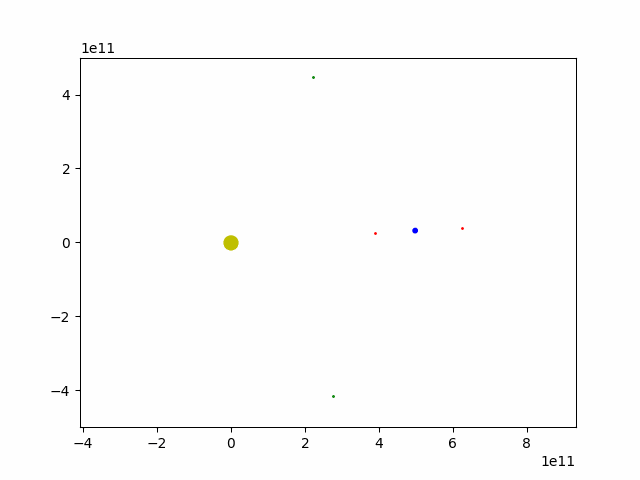

In [113]:
aphe = 5 * 10**11
peri = 2.5 * 10**11
M = 24000
m = 1000
n_m = 10

mass = [1 for i in range(5)]
simulate_lagrange(G, M, m, n_m, aphe, peri, "Lagrange_Points.gif", 2)
Image(filename='Lagrange_Points.gif')

MovieWriter PillowWriter unavailable; using Pillow instead.


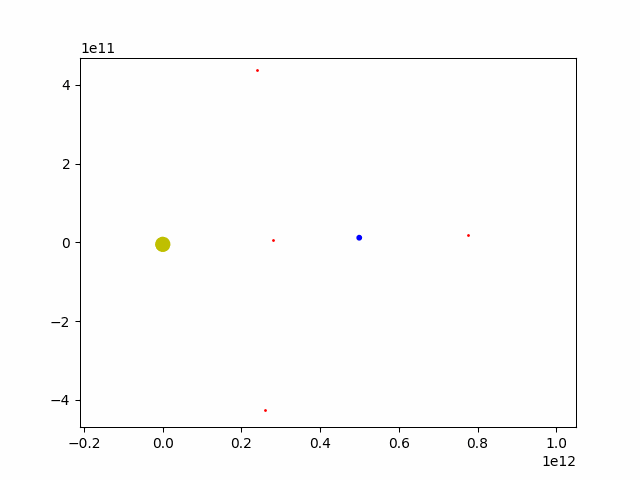

In [114]:
aphe = 5 * 10**11
peri = 1 * 10**11

G = 6.67 * 10**-11
M = 2400
m = 1000

pos, vel = solve_lagrange(G, M, m, 100, aphe, np.array([aphe, 0.0]), get_vel(G, M, m, aphe, peri))
mass = [100 for i in range(5)]
simulate_with_multiple_bodies(G, M, m, aphe, peri, [mass, pos, vel], 3, "Lagrange_Points.gif", 2)
Image(filename='Lagrange_Points.gif')